In [1]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from multiprocessing import Pool, cpu_count
from matplotlib import patches, patheffects
import math
from pathlib import Path

from fastai.dataset import *
from fastai.conv_learner import *
from fastai.imports import *
from fastai.structured import *

import pdb

import pickle
from sklearn.model_selection import train_test_split

from IPython.display import FileLink
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
ddir = "/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge"
rsna_path = Path(ddir)

detailed_class_info_csv = pd.read_csv(rsna_path/'stage_1_detailed_class_info.csv')
stage_1_sample_submission_csv = pd.read_csv(rsna_path/'stage_1_sample_submission.csv')
stage_1_train_labels_csv = pd.read_csv(rsna_path/'stage_1_train_labels.csv')

In [3]:
BBOX_CSV = '../tmp/rsna_bbox.csv'
TRN = 'train'
TEST = 'test2'

In [36]:
f_model=resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)

In [37]:
md = ImageClassifierData.from_csv(rsna_path, TRN, BBOX_CSV, tfms=tfms, bs=64, test_name=TEST, continuous=True, suffix='.dcm')

In [ ]:
# n_sample

In [ ]:
TRN_FILES = list((rsna_path/TRN).glob('*.dcm'))

In [ ]:
RANDOM_TRN_FILES = np.random.shuffle(TRN_FILES)

In [ ]:
n_sample = int(0.10 * len(TRN_FILES))

In [ ]:
(rsna_path/'sample').mkdir(exist_ok=True)
(rsna_path/'sample/train').mkdir(exist_ok=True)
(rsna_path/'sample/test').mkdir(exist_ok=True)

In [ ]:
! ls {rsna_path/'sample'}

In [ ]:
len(stage_1_train_labels_csv)

In [ ]:
df_sample = stage_1_train_labels_csv.sample(n=n_sample).reset_index(); len(df_sample)

In [ ]:
SAMPLE_TRN_LABELS = '../tmp/rsna_train_sample.feather'

In [ ]:
df_sample.to_feather(SAMPLE_TRN_LABELS)

In [ ]:
df_sample = pd.read_feather(SAMPLE_TRN_LABELS)

In [ ]:
def bbox_corners(row):
    x = row['x']
    y = row['y']
    width = row['width']
    height = row['height'] 
    if math.isnan(x):
        return "0 0 0 0"
    
    x2 = x + width
    y2 = y + height
    return f"{x} {y} {x2} {y2}" 

In [ ]:
# of rows where Target = 1
n_rows_target_1 = len(df_sample[df_sample['Target'] != 0])
n_rows_target_1 / n_sample

In [ ]:
df_sample['bbox_corners'] = df_sample.apply(bbox_corners, axis=1)

In [ ]:
df_sample_bbox_corners = df_sample[['patientId', 'bbox_corners']]

In [6]:
BBOX_CSV_CORNERS = '../tmp/df_sample_bbox_corners.csv'

In [9]:
df_sample_bbox_corners.to_csv(BBOX_CSV_CORNERS, index=False)

NameError: name 'df_sample_bbox_corners' is not defined

In [10]:
df_sample_bbox_corners = pd.read_csv(BBOX_CSV_CORNERS)

In [ ]:
df_sample_bbox_corners[:10]

In [11]:
cv_idxs = get_cv_idxs(len(df_sample_bbox_corners), val_pct=0.2)

In [ ]:
len(cv_idxs)

In [38]:
md = ImageClassifierData.from_csv(rsna_path, TRN, BBOX_CSV_CORNERS, 
                                  bs=64, tfms=tfms, val_idxs=cv_idxs, continuous=True, suffix='.dcm')

In [31]:
ds = pydicom.dcmread(str(rsna_path/md.trn_ds.fnames[0]))
size = ds.pixel_array.shape
X_scaling = size[0] / 224. 
Y_scaling = size[1] / 224.

In [39]:
x, y = next(iter(md.trn_dl))

In [45]:
image_data = to_np(md.trn_ds.denorm(x))[1]
bbox = to_np(y[1]).tolist()
x_img, y_img, x2_img, y2_img = bbox

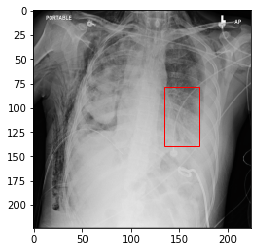

In [46]:
fi, ax = plt.subplots()
ax.imshow(image_data)
rect = Rectangle((x_img,y_img), (x2_img-x_img), (y2_img-y_img), linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)

In [47]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [ ]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 12%|█▏        | 4/33 [00:06<00:49,  1.72s/it, loss=41.1]